In [2]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

def run_query(q):
    with sqlite3.connect('chinook.db') as conn:
        return pd.read_sql(q, conn)
    
def run_command(c):
    with sqlite3.connect('chinook.db') as conn:
        conn.isolation_level = None
        conn.execute(c)
    
def show_tables():
    q = """
        SELECT
        name,
        type
    FROM sqlite_master
    WHERE type IN ("table","view");
        """
    return run_query(q)

In [3]:
show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


## Per genre for USA

In [4]:
q = """
    SELECT 
        sub.Genre, 
        COUNT(sub.Genre) Number_of_Tracks,
        CAST(COUNT(sub.Genre) as float)/
        CAST(
        (SELECT COUNT(track_id) FROM 
            (SELECT il.track_id FROM invoice i
            INNER JOIN invoice_line il
            ON i.invoice_id = il.invoice_id
            WHERE billing_country='USA')) as float) * 100
        AS Perc_of_Total_Tracks
    FROM 
        (SELECT g.name as Genre FROM invoice i
        INNER JOIN invoice_line il
        ON i.invoice_id = il.invoice_id
        INNER JOIN track t
        ON t.track_id = il.track_id
        INNER JOIN genre g
        ON g.genre_id = t.genre_id
        WHERE billing_country='USA') sub
    GROUP BY sub.Genre
    ORDER BY Number_of_Tracks DESC
"""
run_query(q)

,Genre,Number_of_Tracks,Perc_of_Total_Tracks
0,Rock,561,53.377735
1,Alternative & Punk,130,12.369172
2,Metal,124,11.798287
3,R&B/Soul,53,5.042816
4,Blues,36,3.425309
5,Alternative,35,3.330162
6,Latin,22,2.093245
7,Pop,22,2.093245
8,Hip Hop/Rap,20,1.902950
9,Jazz,14,1.332065


In [6]:
# tbl.plot.bar()

From the above study on the number of tracks per genre, the most popular genre is ROCK which contributed more than half of of sales in the US. The runner up goes to PUNK with METAL closely following behind. The top three genres make up the majority (more than 3 quarter) of the tracks sold in the United States. 

## Per sales support agent

In [7]:
q="""
SELECT 
    e.first_name || '-' || e.last_name as "Agent Name", 
    e.hire_date,
    e.birthdate, 
    s.Sales
    FROM employee e 
    INNER JOIN
    (SELECT 
        sub.support_rep_id as employee_id, 
        SUM(sub.unit_price) as Sales
        FROM
            (SELECT c.support_rep_id , il.unit_price FROM customer c
            INNER JOIN invoice i
            ON i.customer_id=c.customer_id
            INNER JOIN invoice_line il
            ON il.invoice_line_id=i.invoice_id) sub
        GROUP BY sub.support_rep_id) as s
    ON s.employee_id=e.employee_id
    ORDER BY s.Sales DESC
"""

run_query(q)

,Agent Name,hire_date,birthdate,Sales
0,Margaret-Park,2017-05-03 00:00:00,1947-09-19 00:00:00,211.86
1,Jane-Peacock,2017-04-01 00:00:00,1973-08-29 00:00:00,209.88
2,Steve-Johnson,2017-10-17 00:00:00,1965-03-03 00:00:00,186.12


In [8]:
q="""
select 
    i.invoice_date, 
    c.support_rep_id from invoice i 
inner join customer c
on c.customer_id=i.customer_id
order by i.invoice_date
limit 10
"""
run_query(q)

,invoice_date,support_rep_id
0,2017-01-03 00:00:00,3
1,2017-01-03 00:00:00,3
2,2017-01-05 00:00:00,4
3,2017-01-06 00:00:00,3
4,2017-01-07 00:00:00,4
5,2017-01-10 00:00:00,5
6,2017-01-12 00:00:00,4
7,2017-01-13 00:00:00,3
8,2017-01-18 00:00:00,3
9,2017-01-18 00:00:00,5


There are three sales support agents in the company. Margaret Park and Jane Peacock had sold more than 200 dollars while Steve Johnson has a bit less. However, considering that Jane and Margaret joined the company 5, 6 months before Steve did, Steve did a pretty good job.

But after looking into the invoice_date, we have found that quite a few invoices were made before they joined the company. Therefore, we have to adjust the query to find out the invoices created during their time of work. Considering those made in the future also belong to the current sales representatives. 

In [9]:
q="""
SELECT 
    e.first_name || '-' || e.last_name as Name, 
    e.hire_date,
    e.birthdate, 
    s.Sales
    FROM employee e 
    INNER JOIN
    (SELECT 
        sub.support_rep_id as employee_id, 
        SUM(sub.unit_price) as Sales
        FROM
            (SELECT 
                c.support_rep_id , 
                il.unit_price
                FROM customer c
                INNER JOIN invoice i
                ON i.customer_id=c.customer_id
                INNER JOIN invoice_line il
                ON il.invoice_line_id=i.invoice_id
                INNER JOIN employee e
                ON c.support_rep_id=e.employee_id
                WHERE e.hire_date<=i.invoice_date
             ) sub
        GROUP BY sub.support_rep_id) as s
    ON s.employee_id=e.employee_id
    ORDER BY s.Sales DESC
"""

run_query(q)

,Name,hire_date,birthdate,Sales
0,Margaret-Park,2017-05-03 00:00:00,1947-09-19 00:00:00,188.10
1,Jane-Peacock,2017-04-01 00:00:00,1973-08-29 00:00:00,187.11
2,Steve-Johnson,2017-10-17 00:00:00,1965-03-03 00:00:00,156.42


Based on the modifed sales numbers, we see the same pattern that Margaret tops the sales chart although she joined the company one month later than Jane. 

## Per country of customers

In [39]:
c='DROP view temp'
run_command(c)

c = '''
CREATE VIEW temp AS
     SELECT
         c.country,
         c.customer_id, 
         i.invoice_id, 
         i.total
         FROM customer c
         INNER JOIN invoice i
         ON i.customer_id = c.customer_id
         ORDER BY 1
'''
run_command(c)

q = 'SELECT * FROM temp;'
run_query(q)

,country,customer_id,invoice_id,total
0,Argentina,56,218,8.91
1,Argentina,56,304,6.93
2,Argentina,56,380,9.90
3,Argentina,56,381,12.87
4,Argentina,56,535,0.99
5,Australia,55,26,1.98
6,Australia,55,90,10.89
7,Australia,55,99,17.82
8,Australia,55,356,6.93
9,Australia,55,427,14.85


In [46]:
c='DROP view q1'
run_command(c)

c1 = """
CREATE VIEW q1 AS
SELECT country, COUNT(customer_id) as number_of_customer
        FROM customer
        GROUP BY 1
"""    
run_command(c1)

c='DROP view q2'
run_command(c)

c2 = """
CREATE VIEW q2 AS
SELECT country, SUM(total) as total_sale
        FROM temp 
        GROUP BY 1
"""
run_command(c2)

In [47]:
c='DROP view q3'
run_command(c)

c3 = """
CREATE VIEW q3 AS
SELECT q1.country, q2.total_sale / q1.number_of_customer as avg_customer_sale
    FROM q1 INNER JOIN q2
    ON q1.country=q2.country

"""
run_command(c3)

In [48]:
c='DROP view q4'
run_command(c)

c4="""
CREATE VIEW q4 AS
    SELECT q2.country, q2.total_sale / o.number_of_order as avg_order
        FROM q2 INNER JOIN
        (SELECT country, COUNT(invoice_id) as number_of_order
                FROM temp 
                GROUP BY 1) o
        ON q2.country=o.country

"""
run_command(c4)

In [56]:
# c='DROP view q'
# run_command(c)

c='''
CREATE VIEW q AS
SELECT q1.*, q2.total_sale, q3.avg_customer_sale, q4.avg_order
FROM q1
INNER JOIN q2 
ON q1.country=q2.country
INNER JOIN q3
ON q2.country=q3.country
INNER JOIN q4
ON q3.country=q4.country
ORDER BY q2.total_sale DESC
'''
run_command(c)

In [63]:
q="select * from q"
run_query(q)

,country,number_of_customer,total_sale,avg_customer_sale,avg_order
0,USA,13,1040.49,80.037692,7.942672
1,Canada,8,535.59,66.948750,7.047237
2,Brazil,5,427.68,85.536000,7.011148
3,France,5,389.07,77.814000,7.781400
4,Germany,4,334.62,83.655000,8.161463
5,Czech Republic,2,273.24,136.620000,9.108000
6,United Kingdom,3,245.52,81.840000,8.768571
7,Portugal,2,185.13,92.565000,6.383793
8,India,2,183.15,91.575000,8.721429
9,Ireland,1,114.84,114.840000,8.833846


In [67]:
q = '''
    SELECT
        c.*,
        CASE
            WHEN c.country = "Other" THEN 1
            ELSE 0
        END AS sort
    FROM 
        (select 
            case when number_of_customer=1 
                then "Other"
                else country
            end as country,
            number_of_customer,
            total_sale,
            avg_customer_sale,
            avg_order
        from q) c   
ORDER BY sort
'''
run_query(q)

,country,number_of_customer,total_sale,avg_customer_sale,avg_order,sort
0,USA,13,1040.49,80.037692,7.942672,0
1,Canada,8,535.59,66.948750,7.047237,0
2,Brazil,5,427.68,85.536000,7.011148,0
3,France,5,389.07,77.814000,7.781400,0
4,Germany,4,334.62,83.655000,8.161463,0
5,Czech Republic,2,273.24,136.620000,9.108000,0
6,United Kingdom,3,245.52,81.840000,8.768571,0
7,Portugal,2,185.13,92.565000,6.383793,0
8,India,2,183.15,91.575000,8.721429,0
9,Other,1,114.84,114.840000,8.833846,1


In [71]:
q = '''
SELECT 
    c.country, 
    SUM(c.number_of_customer) as number_of_customer,
    SUM(c.total_sale) as total_sale,
    AVG(c.avg_customer_sale) as avg_customer_sale,
    AVG(c.avg_order) as avg_order
    FROM
    (SELECT
        c.*,
        CASE
            WHEN c.country = "Other" THEN 1
            ELSE 0
        END AS sort
        FROM 
        (SELECT
            CASE WHEN number_of_customer=1 
                THEN "Other"
                ELSE country
            END AS country,
            number_of_customer,
            total_sale,
            avg_customer_sale,
            avg_order
            FROM q) c  
    ) c
GROUP BY 1
ORDER BY sort, total_sale DESC
'''
run_query(q)

,country,number_of_customer,total_sale,avg_customer_sale,avg_order
0,USA,13,1040.49,80.037692,7.942672
1,Canada,8,535.59,66.948750,7.047237
2,Brazil,5,427.68,85.536000,7.011148
3,France,5,389.07,77.814000,7.781400
4,Germany,4,334.62,83.655000,8.161463
5,Czech Republic,2,273.24,136.620000,9.108000
6,United Kingdom,3,245.52,81.840000,8.768571
7,Portugal,2,185.13,92.565000,6.383793
8,India,2,183.15,91.575000,8.721429
9,Other,15,1094.94,72.996000,7.445071


Based on the table above, we know that USA has the most number of customers with the highest total sales number. However, average spending lper customer in Czech Republic is the highest, so is the average order size. 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x110f6f9b0>,
      dtype=object)

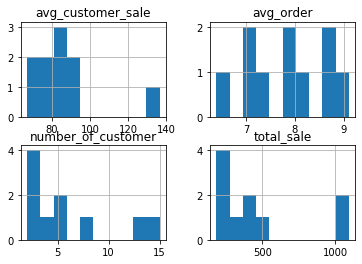

In [72]:
run_query(q).hist()